## Dataset
* Reddit comments from [pushshift.io](https://files.pushshift.io/reddit/comments/)
* About 60k instances in the raw dataset from May & June, 2006

In [317]:
import re
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import random
import json

In [318]:
DATA_DIR = pathlib.Path("./data")

may_reddit_comments_jsonl = DATA_DIR / "RC_2006-05.jsonl"
jun_reddit_comments_jsonl = DATA_DIR / "RC_2006-06.jsonl"
sept_reddit_comments_jsonl = DATA_DIR / "RC_2006-09.jsonl"

In [319]:
df = pd.read_json(
    '\n'.join([
        may_reddit_comments_jsonl.read_text(),
        jun_reddit_comments_jsonl.read_text()
    ]),
    lines=True
)

## Data preprocessing

### Filter out non-English content and possibly spammy content

In [320]:
# pl subreddit is about ~5% and should definitely be excluded.

included_subreddits = [
    "reddit.com",  # 92% of content
    "programming"  # 6% of content
]
df = df[df.subreddit.apply(lambda sr: sr in included_subreddits)]  # Contains 97% of content

### Filter out comments that are too short and too general & remove URLs

In [321]:
def comment_content_filter(text):
    if len(text) < 200:
        return ""
    # Remove URLs
    url_regex = r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    text = re.sub(url_regex, '', text, flags=re.MULTILINE)
    
    return text

filtered_comments = df.body.apply(comment_content_filter)
df.body = filtered_comments
df = df[df.body != ""]
print(f'Reduced to approx. {(len(df)/len(filtered_comments))*100:.2f}% of original content')

Reduced to approx. 35.72% of original content


## Data analysis

### Number of comments per author

In [322]:
df.author.value_counts()

[deleted]       2913
mikepurvis       229
Fountainhead     225
nostrademons     195
senzei           192
                ... 
zekel              1
mlgoss             1
panzagl            1
ejgottl            1
bgraf              1
Name: author, Length: 2165, dtype: int64

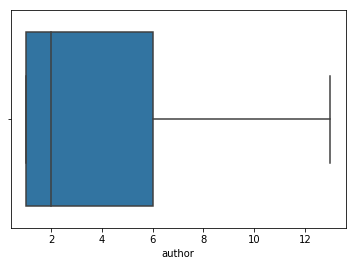

In [303]:
sns.boxplot(df.author.value_counts(), showfliers=False)

In [304]:
sum(df.author.value_counts() > 10)  # Orignally 691

340

In [305]:
sum(df.author.value_counts() > 100)   # Originally 73

25

## Dataset preparation

### All authors criss-crossed –– Model has to truly learn the subtleties in the writing styles

In [325]:
auth_counts = df.author.value_counts()
selected_authors = auth_counts[auth_counts >= 100]
selected_df = df[df.author.apply(lambda auth: auth in selected_authors.keys())]

In [326]:
dataset = {}

for auth, auth_df in selected_df.groupby("author"):
    dataset[auth] = auth_df.body.values.tolist()
    
del dataset["[deleted]"]  # Inconsistent

# Limit counts to 100 for each author
balanced_dataset = {}
for auth in dataset:
    balanced_dataset[auth] = random.sample(dataset[auth], 100)
    

In [327]:
print(f'#authors: {len(balanced_dataset)} \t #samples/author: {len(balanced_dataset["Fountainhead"])}')

#authors: 24 	 #samples/author: 100


In [328]:
train_ds = {}
eval_ds = {}
test_ds = {}
for auth, comments in balanced_dataset.items():
    
    train_ds[auth] = comments[:60]
    eval_ds[auth] = comments[60:80]
    test_ds[auth] = comments[80:]
    
with open("anon_auth_dataset.json", "w+") as out:
    json.dump(obj=[train_ds, eval_ds, test_ds], fp=out)

### Simplified dataset with top two authors –– Model may remember idiosyncrasies in writing styles 

In [330]:
# Top two authors only!

train_ds = {}
eval_ds = {}
test_ds = {}
for auth, comments in dataset.items():
    
    train_ds[auth] = comments[:60]
    eval_ds[auth] = comments[60:80]
    test_ds[auth] = comments[80:]
    
    
simplified_dataset = [
    {"mikepurvis": train_ds["mikepurvis"], "Fountainhead": train_ds["Fountainhead"]},
    {"mikepurvis": eval_ds["mikepurvis"], "Fountainhead": eval_ds["Fountainhead"]},
    {"mikepurvis": test_ds["mikepurvis"], "Fountainhead": test_ds["Fountainhead"]},
]
    
with open("anon_auth_dataset_simplified.json", "w+") as out:
    json.dump(obj=simplified_dataset, fp=out)